In [4]:
#import
import numpy as np 
from PIL import Image
import pydicom as dicom
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
import matplotlib.pyplot as plt 


In [6]:
# 특정 도메인의 픽셀값만 추출하는 함수
# brain, subdural,soft 부분을 추출하기 위해 만듦
def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        return Exception
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

# Save different images as R, G, B: in 3 dimensions
# input : Dicom 데이터셋 인스턴스
# output : 3-channel 이미지
def convert_dcm2img_3ch(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    #brain_img = (brain_img - 0) / 80
    #subdural_img = (subdural_img - (-20)) / 200
    #soft_img = (soft_img - (-150)) / 380
    img_3ch = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    img_3ch = Image.fromarray(np.uint8(img_3ch))
    return img_3ch

In [7]:
#Dicom image =(transform)=> numpy array
#input : dicom_file_path
#output : numpy_array

def dicom2nparray(dcm_file_path):
    dcm_file = dicom.read_file(dcm_file_path)  #해당 파일 위치에 있는 dicom file READ : dcm_file 은 dicom 데이터셋 인스턴스이다. 필드값으로 {pixel_array, patient_id, study_date ... } 등이 있음
    dcm_pixel = dcm_file.pixel_array           #pixel_array 를 받아와서 변수에 저장한다.

    img_array = (dcm_pixel-np.min(dcm_pixel))/(np.max(dcm_pixel)-np.min(dcm_pixel))*255.0    #DICOM 파일은 픽셀값의 범위가 약 -1000 ~ 약 3000 이다. 픽셀값 범위를 0 ~ 255 범위로 정규화 시키겠다.
    img_array = cv2.resize( img_array ,  (224,224) )                                         #img_array 는 사이즈가 (512,512) 이므로, ResNet 에 입력하기 위해 (224,224) 로 resize 한다. 
    #plt.imshow(dcm_pixel , cmap="bone")
    return img_array  #numpy_array 반환

In [25]:
#원본 이미지 데이터(DICOM file)를 모델에 입력할 수 있는 형태(BATCH)로 전처리한다.
#Dicom image =(transform)=> image BATCH
#input : dicom_file_path
#output : image BATCH

def preprocess(dcm_file_path):
    dcm_file = dicom.read_file(dcm_file_path)   #해당 파일 위치에 있는 dicom file READ : dcm_file 은 dicom 데이터셋 인스턴스이다. 
    
    patient_id = dcm_file.PatientID             #환자  ID 받아오기
    study_modality = dcm_file.Modality          #Study Modality 받아오기
    #study_date = dcm_file.StudyDate            #Study Date 받아오기 (지금있는 데이터셋에서는 없어서 주석처리)
    img = convert_dcm2img_3ch(dcm_file)         #dicom 데이터셋 인스턴스를 입력받아서 3채널 이미지로 변환한다. 예 : (512,512,3)    
    img = np.array(img)/255.0                   #해당 이미지 픽셀값을 0 ~ 1 로 정규화한다.
    img = cv2.resize(img , (224,224))           #이미지를 (224,224) 로 resize 한다.
    img = np.expand_dims(img , axis = 0)        #BATCH 로 만들기 위해 축을 하나 추가

    return img,patient_id,study_modality       #BATCH 반환,환자ID,StudyModality

In [54]:
# LIME 결과를 출력한다.
# 위에 predict 가 "hemorrhage" 로 반환할 때에만 실행하도록 조건문 실행 필요
# input : 전처리된 이미지 BATCH file , 원본 이미지(dicom2nparray)
# output : 모델이 예측한 값(normal,hemorrhage) ,lime 으로 붉게 처리된 mask 
# 클래스번호 0 : hemorrhage , 1 : normal
# datagenerator 로 데이터를 받아올때 tensorflow 에서는 class 번호를 알파벳 순으로 부여한다. : "이러한 데이터세트의 class_names 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다."

def predict_and_lime(img_preprocessed , img_original):
    #모델 불러오기
    loaded = keras.models.load_model("C:\\Users\\user\\Desktop\\실리콘밸리 온라인 인턴십\\model\\resnet50_0710_model.h5")
    
    ml_result = loaded.predict(img_preprocessed)[0][0]          #모델의 결과값 받아오기, 참고로 뒤에 sigmoid 함수를 붙였으므로 0에 가까운 값 or 1에 가까운 값이 출력된다

    ml_result = "hemorrhage" if ml_result < 0.2 else "normal"

    if ml_result == "hemorrhage":                                                    #뇌출혈로 예측할 때에만 LIME 실행

        explainer = lime_image.LimeImageExplainer(verbose = False)                   #Lime 인스턴스 생성

        explanation = explainer.explain_instance(                                
            img_preprocessed[0], 
            classifier_fn = loaded.predict, 
            top_labels=5, 
            hide_color=0, 
            num_samples= 1000
        )
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1, hide_rest=False)     # lime 의 이미지랑 마스크 받아오기

        img_colored = np.expand_dims(img_original , axis = -1)                         # 원본 이미지로에 축 하나 추가 : BATCH 
        img_colored = cv2.cvtColor(np.uint8(img_colored),cv2.COLOR_GRAY2RGB)           # 컬러 이미지로 변환
        img_colored[mask != 0] = [255, 0, 0]                                           # 마스크된 부분만 빨간색으로 색칠

        return ml_result,img_colored
    
    else:
        return ml_result
    

In [52]:
# 예시 코드
path = "C:\\Users\\user\\Desktop\\실리콘밸리 온라인 인턴십\\rsna-intracranial-hemorrhage-detection\\train\\"
dcm_file_path = f"{path}ID_00a9af4b1.dcm"
# DICOM 이미지 => 원본 이미지(np array) 
original_img = dicom2nparray(dcm_file_path)     #원본 이미지 받아오기

# DICOM 이미지 => 전처리된 이미지
pre_img = preprocess(dcm_file_path)

In [53]:
pre_img

(array([[[[0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          ...,
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627]],
 
         [[0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          ...,
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627]],
 
         [[0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          ...,
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627],
          [0.        , 0.9254902 , 0.41568627]],
 
         ...,
 
         [[0.        , 0.9254902 , 0.41568627],
          [0.     

In [ ]:
# 전처리된 이미지 => 모델 예측
ai_result = predict_(pre_img[0])

# 원본이미지, 전처리된 이미지 => LIME 결과 이미지
lime_result = lime_explain(pre_img[0] , original_img)

plt.imshow(lime_result)

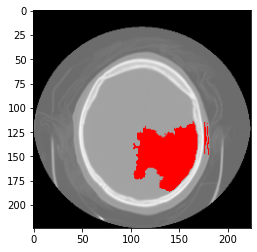

In [40]:
plt.imshow(lime_result)

In [39]:
ai_result

'hemorrhage'

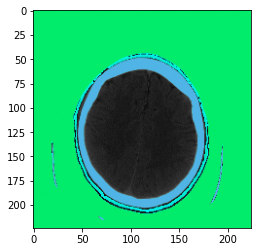

In [41]:
plt.imshow(pre_img[0][0])